### Choose configuration file

In [1]:
include("../src/Dyn3d.jl")
# include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

# include("../src/config_files/2dLink.jl")
# include("../src/config_files/2dFall.jl")
include("../src/config_files/2dSwim.jl")
# include("../src/config_files/2dThrow.jl")
# include("../src/config_files/3dHinge.jl")
# include("../src/config_files/3dPrismatic.jl")
# include("../src/config_files/3dCylindrical.jl")

Config info set up.


### Build joint-body chain

In [2]:
bodys, joints, system = BuildChain(config_bodys, config_joints, 
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 6 body-joint system.
System is un-mounted from space


### Initialize system state

In [3]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs))

nothing

### Time Marching

In [5]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-5 HERK integrator.


In [7]:
# advance in time
idx = 0
@time begin
while soln.t < tf
    # advance one step
    soln, bd.bs, bd.js, bd.sys = herk(soln, bd)
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
        
    # print progress
    idx += 1
    if mod(idx,500) == 1 
        @printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
#         println("center of mass at", MassCenter(bodys, system))
    end
end
@printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
end

itr = 1, t = 0.001, dt = 1.017212e-04
itr = 501, t = 2.819, dt = 5.754051e-03
itr = 712, t = 4.001, dt = 6.066847e-03
  4.522534 seconds (6.01 M allocations: 1.092 GiB, 1.85% gc time)


### Save verts data on regulated time grid for movie in Matlab

In [9]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using MAT
using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = linspace(0,solns[end].t,length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))[t_reg]
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

# write to .mat file for animation
# vs_reg follow the form [ntime][nbody, nverts, xyz]
matwrite("../matlab_plot/verts_i.mat", Dict(
    "ndim" => system.ndim,
    "nbody" => system.nbody,
    "nverts" => bodys[1].nverts,
    "t" => collect(t_reg),
    "verts" => vs_reg
))

### Interactive plot

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ea69576500e078ba4339628269a855bc7ddec092-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ea69576500e078ba4339628269a855bc7ddec092-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_02", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-bd418ef2-6850-4e3a-aab5-3426b13afb3f", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 6),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_01", 3, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/home/fs/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/home/fs/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/home/fs/.julia/v0.6/InteractBase/src/../assets/all.js", "/home/fs/.julia/v0.6/InteractBase/src/../assets/style.css", "/home/fs/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":3}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {return this.value();},this)]\n        
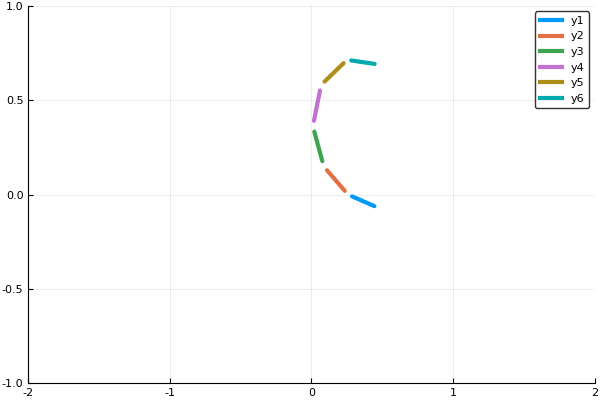
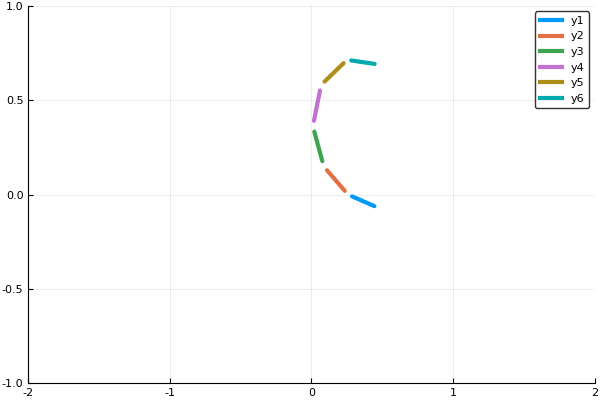

In [10]:
using Reactive, Interact
using Plots
pyplot()

# set intervals of plotting
freq = 100

@manipulate for i in 1:Int(round(length(t_reg)/freq)-1)

    if system.ndim == 2
        k = i*freq+1
        # first body
        plot(vs_reg[k][1,2:3,1],vs_reg[k][1,2:3,2], linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,2:3,1],vs_reg[k][j,2:3,2], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-1,1))
    else
        k = i*freq+1
        h = [1:bodys[1].nverts;1]
        plot(vs_reg[k][1,h,1],vs_reg[k][1,h,2],vs_reg[k][1,h,3]
             , linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,h,1],vs_reg[k][j,h,2],vs_reg[k][j,h,3]
              , linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-1,1))        
    end

end

### Results printed and code efficiency analysis

In [11]:
# # results printed
# solns[end].qJ
# solns[end].v
# solns[end].v̇
# solns[end].λ
# solns[end].t

# # code analysis
# using BenchmarkTools, Compat
# @benchmark HERK!(soln, bodys, joints, system, scheme, tol)
# @profile HERK!(soln, bodys, joints, system, scheme, tol)
# Profile.print()

# using Coverage
# m = analyze_malloc("../src")
# m[end-20:end]